# Multiple Regression: Automotive Deaths by County

### Which attributes, of a US county, correlate to the rate of motor vehicle deaths in that county?

This was our first crack at a building a multiple linear regression model, just to see how it's done and get some practice.

After parsing through some funky data from New York State's **solar panel installation** tax incentive program (https://www.nyserda.ny.gov/All-Programs/Programs/NY-Sun/Data-and-Trends), we realized that said data was not indicative of more general solar panel adoption trends, so we went looking for other data to play with.

A classmate turned us towards (https://datausa.io/map/?level=county&key=uninsured). The next dependent variable we considered was **alcohol-related** motor vehicle deaths, but the metrics were not well defined—compressed into percentages and ambiguous units; we could not use them to extrapolate an actual scalar number of automotive fatalities involving alcohol per county.

For the sake of time, we went with a simpler metric: Given some demographic attributes of a county, could we predict the number of plain old motor vehicle deaths that will happen in a year in that county? Could we do better than just guessing the average for every county? Tl;dr: Yes, linear regression works.

___

### Outline:
#### 1. Data fetching and cleaning
#### 2. Checking for normality and any colinearity
#### 3. Splitting and Scaling the data
#### 4. Making a baseline model
#### 5. Making improved models

___

### 1. Data fetching and cleaning:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn import linear_model, datasets, metrics, preprocessing, pipeline
from sklearn.linear_model import LinearRegression, Lasso
from string import ascii_letters

style.use('ggplot')
sns.set(style="ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
sns.set(style="white")

Just bringing in some data we picked up from https://datausa.io/:

In [2]:
df1, df2 = pd.read_csv('data/drunkdrivin_01.csv'), pd.read_csv('data/drunkdrivin_02.csv')
df3, df4 = pd.read_csv('data/drunkdrivin_03.csv'), pd.read_csv('data/drunkdrivin_04.csv')
df5 = pd.read_csv('data/drunkdrivin_05.csv')

In [3]:
joiner = pd.merge(df1, df2, how='left', on='geo_name')
joiner = pd.merge(joiner, df3, how='left', on='geo_name')
joiner = pd.merge(joiner, df4, how='left', on='geo_name')
joiner = pd.merge(joiner, df5, how='left', on='geo_name')

In [4]:
joiner.head() # Here's the kitchen sink of our data:

,geo_name,geo_sumlevel_x,geo_id_x,alcoholimpaired_driving_deaths_2015,alcoholimpaired_driving_deaths_2016,alcoholimpaired_driving_deaths_2017,income_below_poverty:pop_poverty_status_2013,income_below_poverty:pop_poverty_status_2014,income_below_poverty:pop_poverty_status_2015,income_below_poverty:pop_poverty_status_2016,income_2013,income_2014,income_2015,income_2016,income_below_poverty_2013,income_below_poverty_2014,income_below_poverty_2015,income_below_poverty_2016,pop_poverty_status_2013,pop_poverty_status_2014,pop_poverty_status_2015,pop_poverty_status_2016,unemployment_2015,unemployment_2016,unemployment_2017,uninsured_2015,uninsured_2016,uninsured_2017,geo_sumlevel_y,geo_id_y,high_school_graduation_2015,high_school_graduation_2016,high_school_graduation_2017,mean_commute_minutes_2013,mean_commute_minutes_2014,mean_commute_minutes_2015,mean_commute_minutes_2016,motor_vehicle_crash_deaths_2015,motor_vehicle_crash_deaths_2016,motor_vehicle_crash_deaths_2017,population_living_in_a_rural_area_2015,population_living_in_a_rural_area_2016,population_living_in_a_rural_area_2017,severe_housing_problems_2015,severe_housing_problems_2016,severe_housing_problems_2017,geo_sumlevel_x,geo_id_x,adult_obesity_2015,adult_obesity_2016,adult_obesity_2017,medicare_beneficiaries_total_2010,medicare_beneficiaries_total_2011,medicare_beneficiaries_total_2012,medicare_beneficiaries_total_2013,medicare_beneficiaries_total_2014,social_associations_2015,social_associations_2016,social_associations_2017,teen_births_2015,teen_births_2016,teen_births_2017,violent_crime_2015,violent_crime_2016,violent_crime_2017,geo_sumlevel_y,geo_id_y,food_insecurity_2015,food_insecurity_2016,food_insecurity_2017,poor_mental_health_days_2015,poor_mental_health_days_2016,poor_mental_health_days_2017,geo_sumlevel,geo_id,pop_2013,pop_2014,pop_2015,pop_2016
0,"Autauga County, AL",county,05000US01001,0.333,0.318,0.327,0.121334,0.128052,0.128794,0.122660,53682.0,52475.0,51281.0,53099.0,6615.0,7006.0,7057.0,6697.0,54519.0,54712.0,54793.0,54598.0,0.057,0.059,0.052,0.128,0.134,0.110,county,05000US01001,0.810,0.830,0.900,25.6470,26.3211,26.0002,25.5584,21.25,19.72,18.94,0.420,0.420,0.420,0.123,0.136,0.147,county,05000US01001,0.313,0.309,0.341,NaN,NaN,NaN,NaN,NaN,13.150,13.757,13.720,36.5,35.2,32.4,253.64,253.64,265.70,county,05000US01001,0.135,0.139,0.144,3.6,4.3,4.2,county,05000US01001,54907.0,55136.0,55221.0,55049.0
1,"Baldwin County, AL",county,05000US01003,0.303,0.394,0.342,0.139407,0.137768,0.134117,0.129938,50221.0,50183.0,50254.0,51365.0,25752.0,25988.0,25798.0,25551.0,184725.0,188636.0,192355.0,196640.0,0.058,0.061,0.055,0.158,0.175,0.161,county,05000US01003,0.740,0.800,0.850,25.0430,25.5477,25.3936,25.8497,16.57,15.90,15.32,0.423,0.423,0.423,0.141,0.147,0.147,county,05000US01003,0.250,0.267,0.274,20820.0,21017.0,21668.0,22333.0,23020.0,11.636,12.018,11.544,44.5,41.6,38.0,220.67,220.67,216.77,county,05000US01003,0.135,0.137,0.137,3.8,4.2,4.0,county,05000US01003,187114.0,191205.0,195121.0,199510.0
2,"Barbour County, AL",county,05000US01005,0.435,0.391,0.385,0.266568,0.240842,0.267274,0.263737,32911.0,35634.0,32964.0,33956.0,6512.0,5832.0,6421.0,6235.0,24429.0,24215.0,24024.0,23641.0,0.100,0.108,0.089,0.175,0.174,0.153,county,05000US01005,0.697,0.805,0.862,24.0734,23.9553,23.6957,23.4419,18.67,18.22,18.96,0.678,0.678,0.678,0.186,0.176,0.162,county,05000US01005,0.384,0.408,0.444,3166.0,2920.0,3010.0,3094.0,3132.0,8.456,8.125,8.182,72.9,67.9,59.0,146.89,146.89,328.66,county,05000US01005,0.227,0.223,0.233,4.3,4.7,4.8,county,05000US01005,27321.0,27119.0,26932.0,26614.0
3,"Bibb County, AL",county,05000US01007,0.310,0.344,0.333,0.181378,0.170427,0.167959,0.164539,36447.0,37984.0,38678.0,39776.0,3898.0,3596.0,3488.0,3390.0,21491.0,21100.0,20767.0,20603.0,0.068,0.071,0.066,0.151,0.150,0.136,county,05000US01007,0.800,0.810,0.850,27.2696,26.6577,28.5487,28.6987,25.87,23.92,22.04,0.684,0.684,0.684,0.096,0.130,0.137,county,05000US01007,0.373,0.401,0.403,1792.0,1820.0,1923.0,1844.0,1

Weeding out the non-2016 data and other trash:

In [5]:
df = joiner[['geo_name', 'motor_vehicle_crash_deaths_2016',
             'income_2016', 'pop_2016',
             #'income_below_poverty_2016', 'pop_poverty_status_2016',
             'unemployment_2016', 'uninsured_2016', 'high_school_graduation_2016',
             'mean_commute_minutes_2016','alcoholimpaired_driving_deaths_2016', 
             'population_living_in_a_rural_area_2016', 'severe_housing_problems_2016',
             'adult_obesity_2016', 'social_associations_2016', 'teen_births_2016',
             'violent_crime_2016', 'food_insecurity_2016', 'poor_mental_health_days_2016'
            ]].copy()

Dropping null rows for some upcoming joins:

In [6]:
df = df.dropna()

#### First five rows of the data:

In [7]:
df.head().columns

Index(['geo_name', 'motor_vehicle_crash_deaths_2016', 'income_2016',
       'pop_2016', 'unemployment_2016', 'uninsured_2016',
       'high_school_graduation_2016', 'mean_commute_minutes_2016',
       'alcoholimpaired_driving_deaths_2016',
       'population_living_in_a_rural_area_2016',
       'severe_housing_problems_2016', 'adult_obesity_2016',
       'social_associations_2016', 'teen_births_2016', 'violent_crime_2016',
       'food_insecurity_2016', 'poor_mental_health_days_2016'],
      dtype='object')

Car crash deaths per 100k population is the value we're trying to predict.

Then we'll grab some political data:

In [8]:
url = 'https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv'
prez = pd.read_csv(url)

Some munging is required:

In [9]:
prez1 = prez.drop(['per_point_diff', 'diff'], axis=1)
prez1['trumpy'] = prez1['per_dem'] < prez1['per_gop']
prez1['trumpy'] = (prez1['trumpy'] == True).astype(int)

In [10]:
counties = []
for i in df.values:
        counties.append(i[0].split(',')[0]) # Getting rid of commas and states in county names
df['geo_name'] = np.array(counties)        

Making sure our columns match before merges:

In [11]:
prez1.columns = ['Unnamed: 0', 'votes_dem', 'votes_gop', 'total_votes', 'per_dem',
       'per_gop', 'state_abbr', 'geo_name', 'combined_fips', 'trumpy']

prez = prez1[['geo_name','trumpy']].copy()

In [12]:
prez['geo_name'] = prez.geo_name.str.upper()
prez_final = prez[29:]

In [13]:
df['geo_name'] = df.geo_name.str.upper() # More merge prep - join will be on county names

Merging in political data to our initial county data:

In [14]:
df = pd.merge(df, prez_final.drop_duplicates(subset=['geo_name']), how='left', on='geo_name')

New first 5 rows:

In [15]:
df.head()

,geo_name,motor_vehicle_crash_deaths_2016,income_2016,pop_2016,unemployment_2016,uninsured_2016,high_school_graduation_2016,mean_commute_minutes_2016,alcoholimpaired_driving_deaths_2016,population_living_in_a_rural_area_2016,severe_housing_problems_2016,adult_obesity_2016,social_associations_2016,teen_births_2016,violent_crime_2016,food_insecurity_2016,poor_mental_health_days_2016,trumpy
0,AUTAUGA COUNTY,19.72,53099.0,55049.0,0.059,0.134,0.830,25.5584,0.318,0.420,0.136,0.309,13.757,35.2,253.64,0.139,4.3,1.0
1,BALDWIN COUNTY,15.90,51365.0,199510.0,0.061,0.175,0.800,25.8497,0.394,0.423,0.147,0.267,12.018,41.6,220.67,0.137,4.2,1.0
2,BARBOUR COUNTY,18.22,33956.0,26614.0,0.108,0.174,0.805,23.4419,0.391,0.678,0.176,0.408,8.125,67.9,146.89,0.223,4.7,1.0
3,BIBB COUNTY,23.92,39776.0,22572.0,0.071,0.150,0.810,28.6987,0.344,0.684,0.130,0.401,9.773,48.4,235.95,0.162,4.6,1.0
4,BLOUNT COUNTY,24.67,46212.0,57704.0,0.061,0.176,0.850,34.3258,0.192,0.900,0.123,0.324,8.467,45.3,219.03,0.121,4.5,1.0


Some final cleanup before we start exploring our data:

In [16]:
df = df.dropna() # We're row-rich enough to drop annoying null columns including Alaska
df['trumpy'] = df['trumpy'].astype('category')

Separating our target column from all the feature columns:

In [17]:
features = df.iloc[:,2:]
target = df.iloc[:,1]

Now we have our **features** columns and a **target** column.

### 2. Checking for normality and any colinearity

#### Are our features normally distributed?

/Users/rob/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


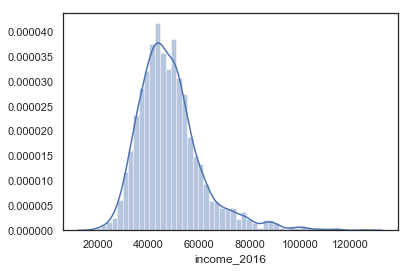

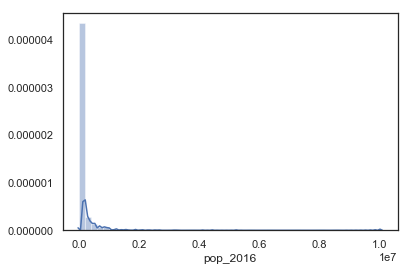

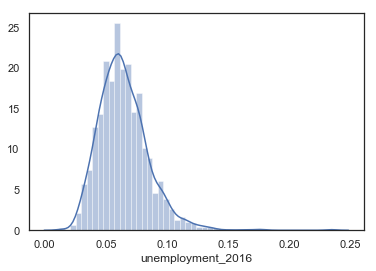

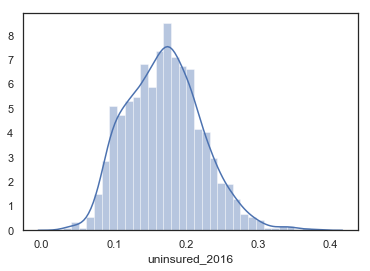

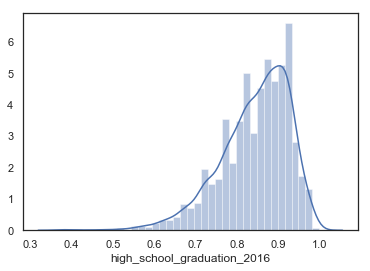

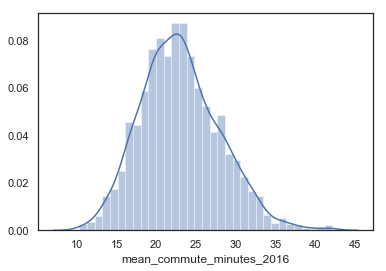

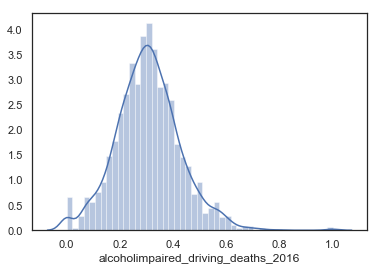

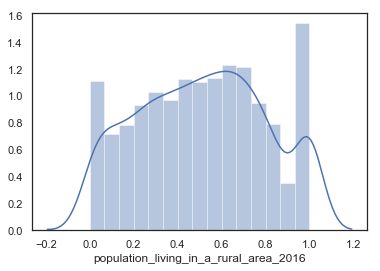

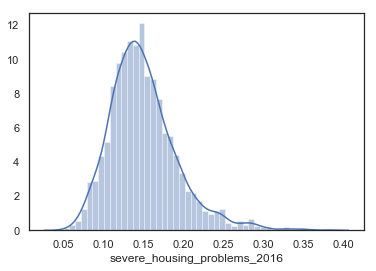

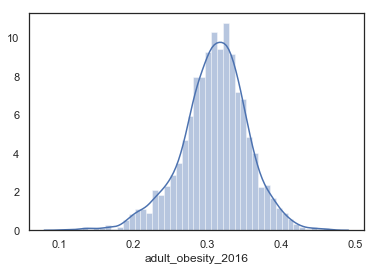

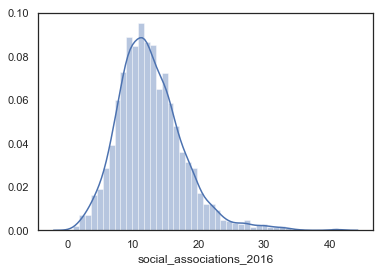

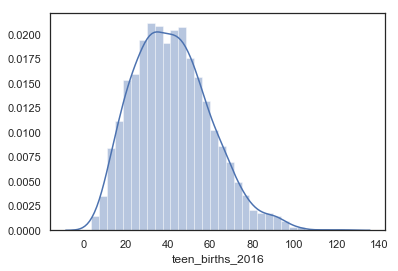

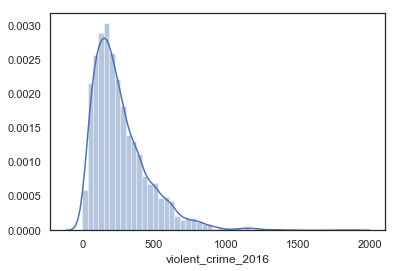

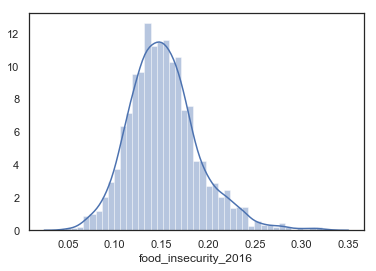

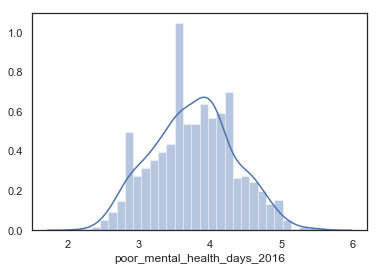

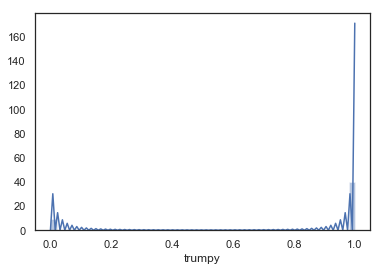

In [18]:
for column in features:
    ax = sns.distplot(features[column])
    plt.show()

#### Are there any obvious linear correlations?

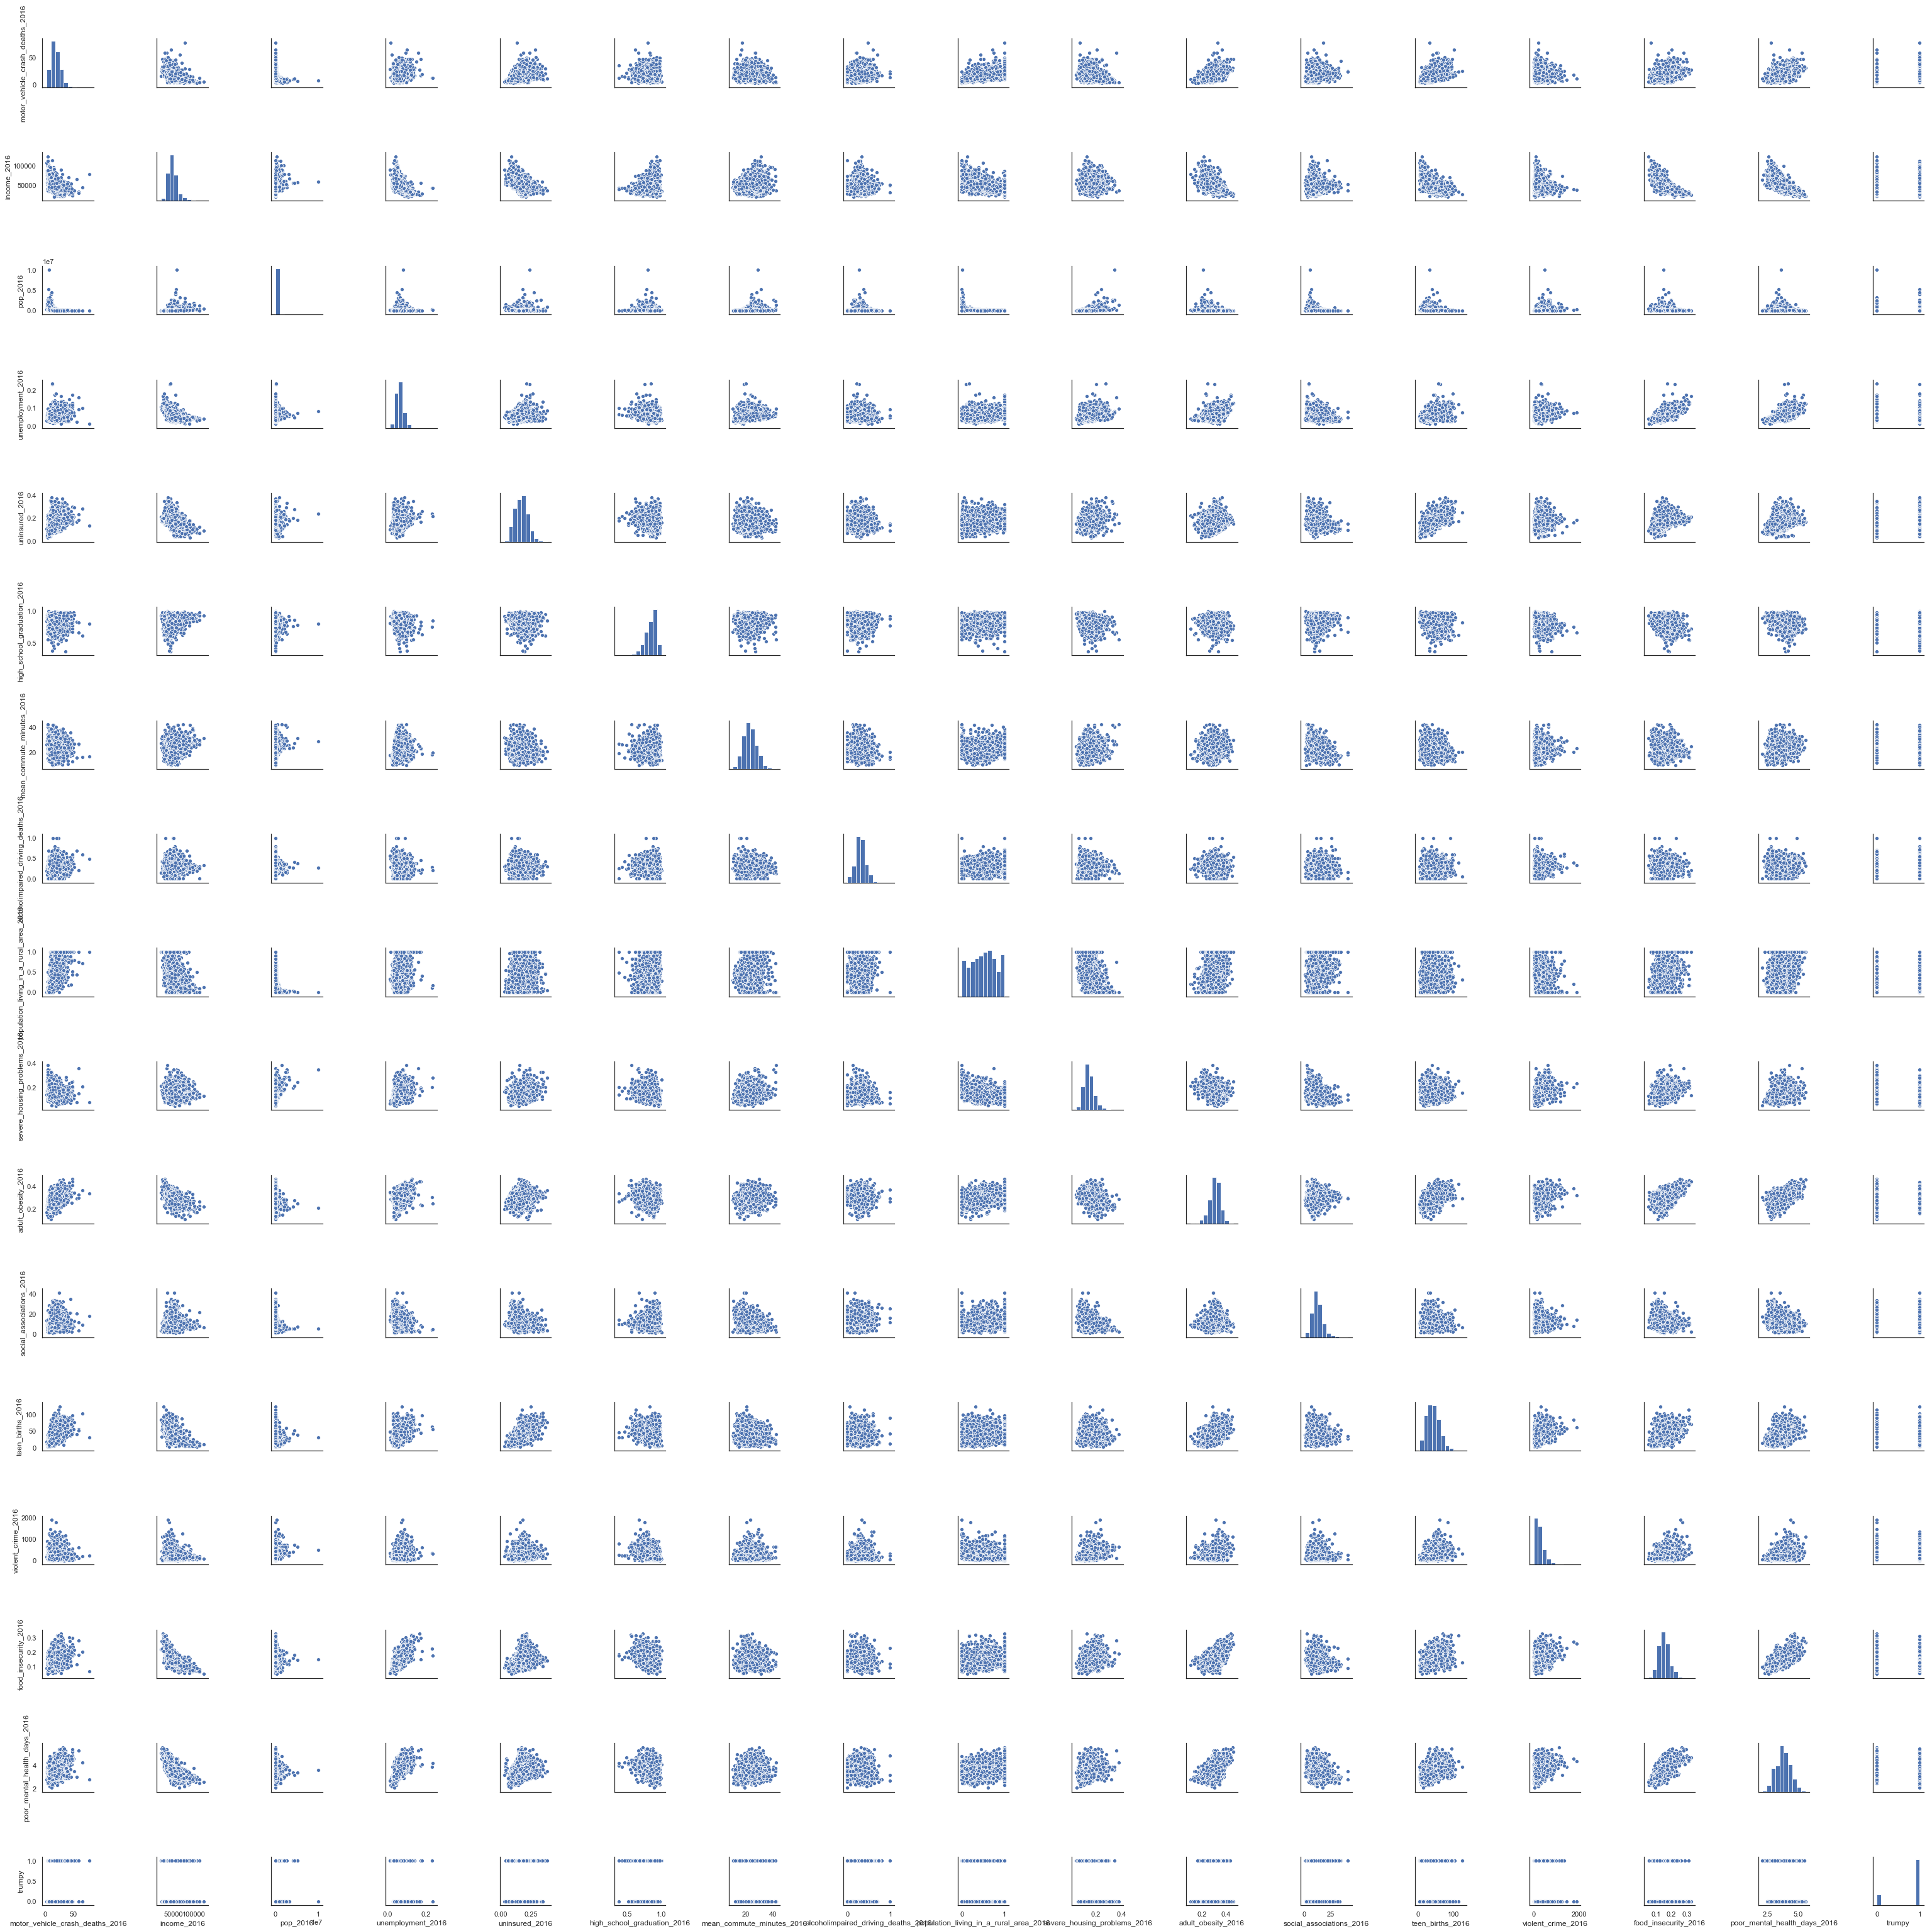

In [61]:
sns.pairplot(df) # This takes forever to run never run ever ever

### 3. Splitting and Scaling the data

**Splitting:**

Now we must separate our main dataset into two blocks, one for training our model and another for testing how it does.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=39, test_size=0.2)

Just making some copies of our variables here for later down:

In [21]:
X_train_orig = X_train 
X_test_orig = X_test
y_train_orig = y_train
y_test_orig = y_test

**Scaling:**

Here we will put all our data in units of standard deviations from the mean.

In [22]:
scaler = preprocessing.StandardScaler()

In [23]:
scaler.fit(features.iloc[:,:-1])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)

features_scaled_train['trumpy']= X_train.trumpy
fst_train = features_scaled_train # making a backup for later


#### Here's our training data:

In [25]:
features_scaled_train.head()

,income_2016,pop_2016,unemployment_2016,uninsured_2016,high_school_graduation_2016,mean_commute_minutes_2016,alcoholimpaired_driving_deaths_2016,population_living_in_a_rural_area_2016,severe_housing_problems_2016,adult_obesity_2016,social_associations_2016,teen_births_2016,violent_crime_2016,food_insecurity_2016,poor_mental_health_days_2016,trumpy
1665,0.795095,0.397233,-1.339249,-0.112810,-0.156857,-0.122079,-0.095877,-1.184874,-0.230521,-0.243168,-0.932136,-1.053452,0.390230,-0.047675,0.589772,1.0
1054,-0.407368,-0.176693,0.458579,-0.673040,0.331784,1.258898,0.667991,1.160035,0.409958,0.625032,0.161314,-0.210115,-0.187228,0.137737,0.245017,1.0
1244,-1.496332,-0.310794,0.409989,0.119010,0.665490,-1.326618,-0.876173,-0.637614,0.409958,0.491463,0.970869,2.506087,1.315115,1.674010,1.279281,1.0
1794,-0.670059,3.936245,0.750118,-0.093491,-1.467847,1.741761,-0.506559,-1.770236,2.212787,-0.398999,-0.983298,0.507269,4.620953,1.568060,1.796414,0.0
1077,-0.244947,-0.224163,-0.610400,-0.518494,-1.527437,-0.931803,-0.054809,0.553891,0.386236,-0.510306,-0.256805,0.490840,0.085816,-0.418500,-0.789248,1.0


#### And here's our testing data:

In [26]:
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.columns[:-1], index=X_test.index)

features_scaled_test['trumpy']= X_test.trumpy
fst_test = features_scaled_test # Backup

features_scaled_test.head()


,income_2016,pop_2016,unemployment_2016,uninsured_2016,high_school_graduation_2016,mean_commute_minutes_2016,alcoholimpaired_driving_deaths_2016,population_living_in_a_rural_area_2016,severe_housing_problems_2016,adult_obesity_2016,social_associations_2016,teen_births_2016,violent_crime_2016,food_insecurity_2016,poor_mental_health_days_2016,trumpy
1365,4.684509,-0.004193,-0.853349,-1.793501,1.285231,1.526726,-0.416209,-0.052252,0.386236,-2.157660,-0.491145,-2.093933,-1.109654,-2.140185,-1.306380,1.0
1553,-0.631705,-0.125329,1.381787,0.601967,-0.514400,-0.581444,0.528359,-0.429793,1.169044,1.582278,-0.231927,0.709889,0.760846,1.753472,0.589772,1.0
794,0.811846,-0.136017,-0.270270,-0.634404,0.081504,0.852989,-0.991164,-0.717278,-0.942164,0.357893,-1.131566,-0.571545,-0.770207,-0.789324,0.072639,1.0
1938,0.250300,0.171645,0.118449,-0.557130,1.154132,0.201380,-0.186227,-1.087892,-0.135635,-0.398999,-1.037469,0.036314,1.406414,0.349637,1.106904,0.0
378,-1.717694,-0.325534,2.645125,0.621285,0.975361,0.549101,-1.024018,0.363389,1.809523,1.114786,-1.863275,-0.084162,-0.770106,3.263258,1.279281,0.0


### 4. Making a baseline model

The most basic form of predicting outcomes is just assuming it will be the average:

In [27]:
np.mean(y_train)

18.53214905564063

In [28]:
# np.full((len(y_test), ), np.mean(y_train))

In [29]:
the_mean = np.full((len(y_test), ), np.mean(y_train))

print("MSE: ",metrics.mean_squared_error(y_test, the_mean))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, the_mean)))
basic_rmse = np.sqrt(metrics.mean_squared_error(y_test, the_mean))

MSE:  69.91189669457229
RMSE:  8.361333428022848


### 5. Making improved models

Here's what we get when we throw ALL of our variables at a model:

In [30]:
outcome = 'motor_vehicle_crash_deaths_2016'
predictors = df.iloc[:,2:]
predictors
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     motor_vehicle_crash_deaths_2016   R-squared:                       0.600
Model:                                         OLS   Adj. R-squared:                  0.597
Method:                              Least Squares   F-statistic:                     227.5
Date:                             Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                                     18:16:06   Log-Likelihood:                -7547.1
No. Observations:                             2449   AIC:                         1.513e+04
Df Residuals:                                 2432   BIC:                         1.523e+04
Df Model:                                       16                                         
Covariance Type:                         nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                -10.4969      2.559     -4.102      0.000     -15.515      -5.479
trumpy[T.1.0]                             -0.3946      0.303     -1.303      0.193      -0.989       0.199
income_2016                             6.012e-05   1.76e-05      3.411      0.001    2.56e-05    9.47e-05
pop_2016                               -5.549e-07   3.49e-07     -1.589      0.112   -1.24e-06     1.3e-07
unemployment_2016                        -16.5423      7.829     -2.113      0.035     -31.895      -1.190
uninsured_2016                            30.9611      3.216      9.628      0.000      24.655      37.267
high_school_graduation_2016                1.9507      1.453      1.343      0.180      -0.899       4.800
mean_commute_minutes_2016                 -0.0166      0.030     -0.560      0.575      -0.075       0.042
alcoholimpaired_driving_deaths_2016        2.4324      0.889      2.736      0.006       0.689       4.176
population_living_in_a_rural_area_2016    14.2704      0.588     24.288      0.000      13.118      15.423
severe_housing_problems_2016             -18.7741      3.821     -4.913      0.000     -26.267     -11.281
adult_obesity_2016                         8.8401      3.456      2.558      0.011       2.062      15.618
social_associations_2016                   0.0640      0.027      2.365      0.018       0.011       0.117
teen_births_2016                           0.1450      0.010     15.085      0.000       0.126       0.164
violent_crime_2016                         0.0019      0.001      2.699      0.007       0.001       0.003
food_insecurity_2016                      23.5415      4.852      4.852      0.000      14.027      33.056
poor_mental_health_days_2016               0.5622      0.293      1.920      0.055      -0.012       1.136
==============================================================================
Omnibus:                      878.381   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7346.553
Skew:                           1.459   Prob(JB):                         0.00
Kurtosis:                      10.967   Cond. No.                     2.91e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We get an r^2 of .60, which is not the best.

In [31]:
print("MSE: ", model.mse_total)
print("RMSE: ", model.mse_total**.5)
allvars_rmse = model.mse_total**.5

MSE:  69.47824161759368
RMSE:  8.335360917056542


In [32]:
print('Percent improvement over the mean: ', 1-allvars_rmse/basic_rmse)

Percent improvement over the mean:  0.0031062642328385515


#### Filter Methods and Feature Engineering

Maybe we can do better with some feature filtering methods.

Referencing the p-values of the above test, we decide to manually drop some columns:

In [33]:
features_scaled_train = features_scaled_train.drop(['pop_2016',
                                                    'mean_commute_minutes_2016',
                                                   'high_school_graduation_2016',
                                                    'trumpy',
                                                    'poor_mental_health_days_2016'
                                                   ], axis=1)

features_scaled_test = features_scaled_test.drop(['pop_2016',
                                                  'mean_commute_minutes_2016',
                                                   'high_school_graduation_2016',
                                                    'trumpy',
                                                    'poor_mental_health_days_2016'], axis=1)

Now we engineer **a bunch of crazy polynomial and interaction terms:**

In [34]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
poly_features_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))


In [35]:
poly_features_test.columns

Index(['income_2016', 'unemployment_2016', 'uninsured_2016',
       'alcoholimpaired_driving_deaths_2016',
       'population_living_in_a_rural_area_2016',
       'severe_housing_problems_2016', 'adult_obesity_2016',
       'social_associations_2016', 'teen_births_2016', 'violent_crime_2016',
       'food_insecurity_2016', 'income_2016^2',
       'income_2016 unemployment_2016', 'income_2016 uninsured_2016',
       'income_2016 alcoholimpaired_driving_deaths_2016',
       'income_2016 population_living_in_a_rural_area_2016',
       'income_2016 severe_housing_problems_2016',
       'income_2016 adult_obesity_2016',
       'income_2016 social_associations_2016', 'income_2016 teen_births_2016',
       'income_2016 violent_crime_2016', 'income_2016 food_insecurity_2016',
       'unemployment_2016^2', 'unemployment_2016 uninsured_2016',
       'unemployment_2016 alcoholimpaired_driving_deaths_2016',
       'unemployment_2016 population_living_in_a_rural_area_2016',
       'unemployment_201

That's a whole lot of columns. Some of them might be colinear:

Let's drop any **columns with not enough variance to care about:**

In [36]:
def variance_threshold_selector(data, threshold=1.2):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(poly_features_train)

In [37]:
print('Number of Columns Before: ',len(poly_features_train.columns))
print('Number of Columns After: ',len(features_selected_train.columns))

Number of Columns Before:  77
Number of Columns After:  35


Next, we'll check to see if there is much obvious **colinearity** happening between our features:

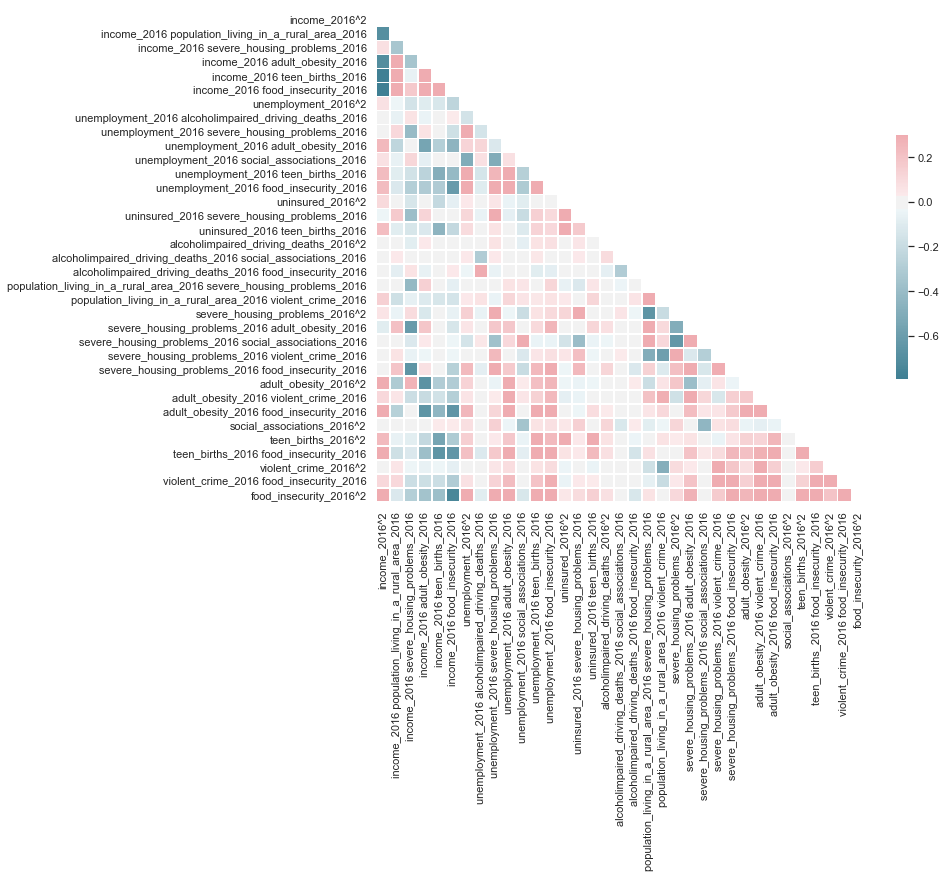

In [38]:
corr = features_selected_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In order to **drop colinear/redundant features**, we look at **correlation coefficients** between all our features:

In [39]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

In [40]:
features_selected_train.drop(columns=to_drop, inplace=True)

/Users/rob/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [41]:
print('Current columns: ',len(features_selected_train.columns) )# Down to just 32 columns

Current columns:  32


We can run a function to **pick the K most predictive features**:

In [42]:
def information_selector(X, y, scoring, k):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [43]:
features_selected_train = information_selector(features_selected_train, 
                                               y_train, mutual_info_regression, 
                                               k=15)

In [44]:
features_selected_test = poly_features_test[features_selected_train.columns]

#### Now we train our model with the filtered features:

In [45]:
lm = linear_model.LinearRegression()
lm.fit(features_selected_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
print('R^2: ', lm.score(features_selected_train, y_train))

R^2:  0.13982651170618254


In [47]:
print('R^2: ', lm.score(features_selected_test, y_test))

R^2:  0.11652263260415685


In [48]:
filtered_y_preds = lm.predict(features_selected_test)

In [49]:
print("MSE: ",metrics.mean_squared_error(y_test, filtered_y_preds))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, filtered_y_preds)))
improved_rmse = np.sqrt(metrics.mean_squared_error(y_test, filtered_y_preds))

MSE:  61.756596306296316
RMSE:  7.858536524461556


In [50]:
print('Percent improvement over the mean: ', 1-improved_rmse/basic_rmse)

Percent improvement over the mean:  0.06013357891890514


Here's an X vs Y plot, which, if it were perfect, would be a straight line:

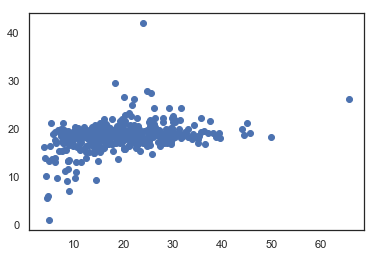

In [51]:
plt.scatter(y_test, filtered_y_preds)

### Lasso

As an alternative to manually filtering features, we also tried Lasso Regression. Lasso or L1 helps reduce overfitting in addition to automatically filtering features, effectively.

In [52]:
from sklearn.linear_model import LassoCV

In [53]:
alphas = np.array(list(range(1,100)))/10000000
lassoReg = LassoCV(alphas=alphas, normalize=True)

lasso_xtrain = pd.DataFrame(poly.fit_transform(fst_train), columns=poly.get_feature_names(fst_train.columns))
lasso_xtest  = pd.DataFrame(poly.fit_transform(fst_test), columns=poly.get_feature_names(fst_test.columns))

lassoReg.fit(lasso_xtrain,y_train_orig)
y_pred = lassoReg.predict(lasso_xtest)

/Users/rob/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/rob/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rob/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. Yo

Here's a graph of our model's **coefficients**, aka **weights**, aka **betas**, aka:

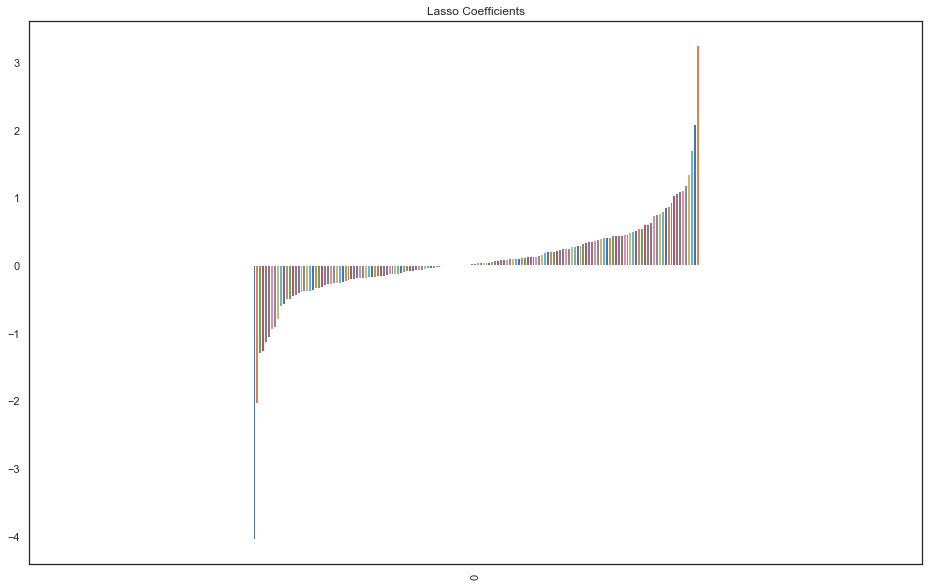

In [54]:
coef = pd.DataFrame(data = lassoReg.coef_, index=lasso_xtrain.columns)
model_coef = coef.sort_values(by=0).T
model_coef.plot(kind='bar', title='Lasso Coefficients', legend=False, figsize=(16,10))

Our new Lasso r-squared, aka how much of the variance in our data is explained by the model:

In [55]:
print('R^2: ',lassoReg.score(lasso_xtest, y_test_orig))

R^2:  0.6524636212925266


In [56]:
lasso_y_preds = lassoReg.predict(lasso_xtest)

In [57]:
print("MSE: ",metrics.mean_squared_error(y_test, lasso_y_preds))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, lasso_y_preds)))
lasso_rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso_y_preds))

MSE:  24.29339407397991
RMSE:  4.928832932244703


In [58]:
print('Percent improvement over the mean: ', 1-lasso_rmse/basic_rmse)

Percent improvement over the mean:  0.41052070525906614


Predicting the number of car crashes based on # of births per 1,000 female population, ages 15-19:

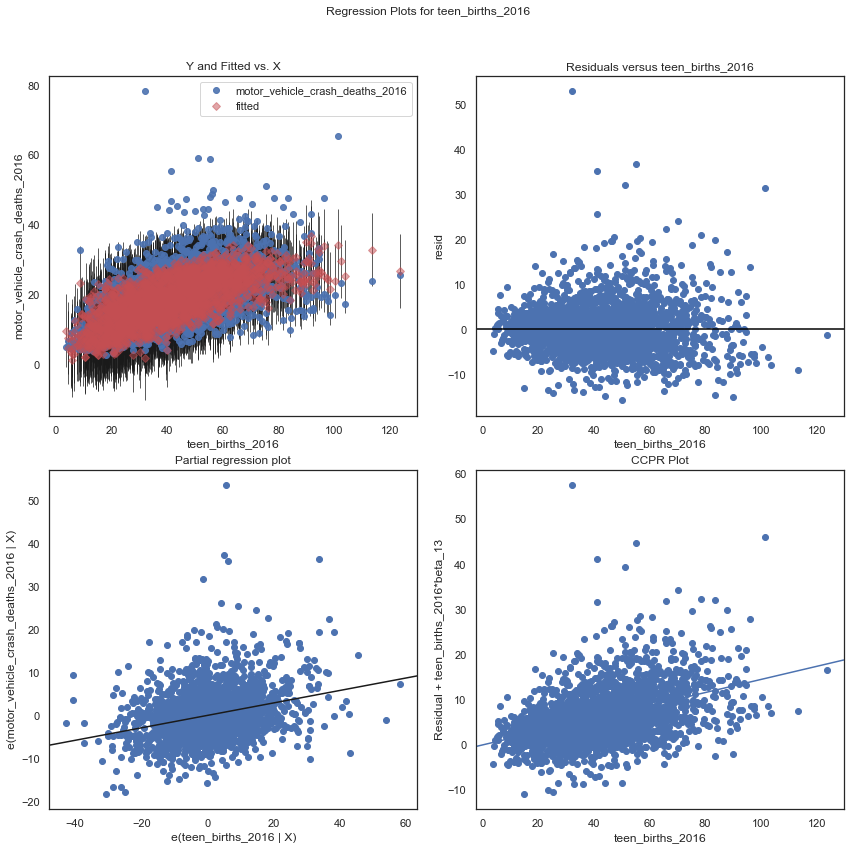

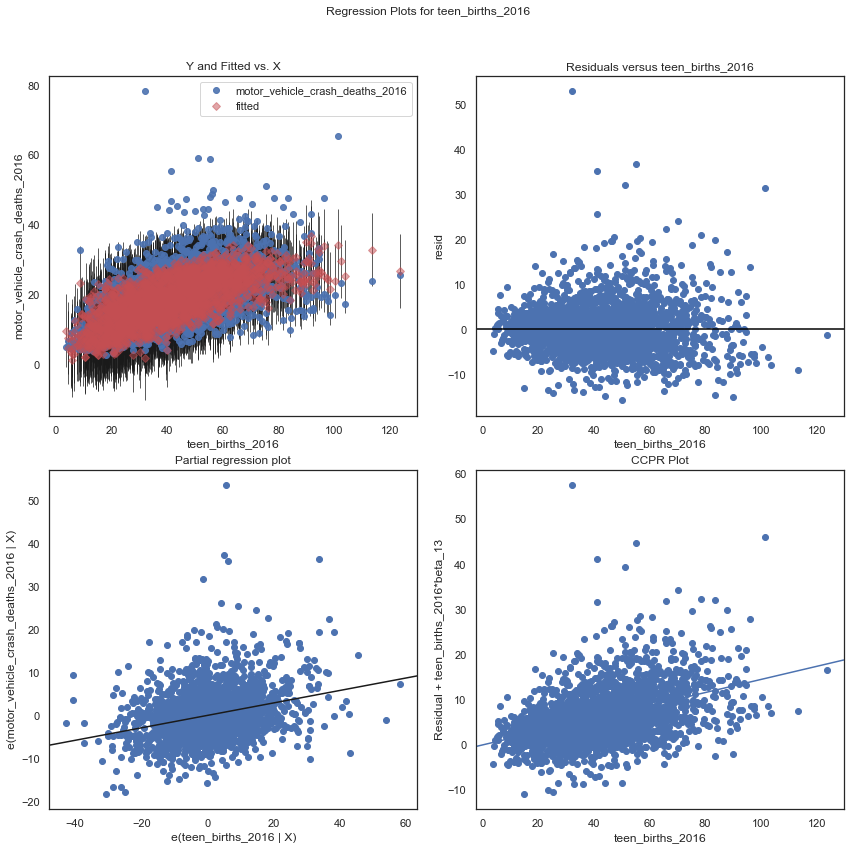

In [59]:
fig = plt.figure(figsize=(12,12))
sm.graphics.plot_regress_exog(model, "teen_births_2016", fig=fig)

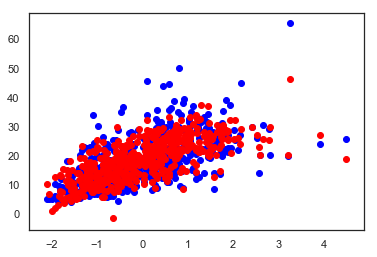

In [60]:
ax1 = plt.scatter(lasso_xtest['teen_births_2016'], y_test, c='blue')
ax2 = plt.scatter(lasso_xtest['teen_births_2016'], lasso_y_preds, c='red')

## Takeaways:

* A deep understanding of your initial data set and its provenance is imperative.
* Resilience and flexibility are key characteristics of a data scientist.
* In our multiple linear regression model, the two strongest features for predicting the motor vehicle death rate in any given US county are **teen childbearing rates** and the percentage of that county's **population that lives in a rural area.**
* We had to pivot from several previous ideas, and chose these features because they were handy in the available data set.  Ultimately, these particular features are probably not the best ones for predicting the number of **motor vehicle deaths** in any given US county.